# Ridesharing Analysis
You're working as an analyst for Zuber, a new ride-sharing company that's launching in Chicago. Your task is to find patterns in the available information. You want to understand passenger preferences and the impact of external factors on rides.

You'll study a database, analyze data from competitors, and test a hypothesis about the impact of weather on ride frequency.

**Step 1**

Parse the data on weather in Chicago in November 2017 from the website:
[https://code.s3.yandex.net/data-analyst-eng/chicago_weather_2017.html)

In [2]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

URL = 'https://code.s3.yandex.net/data-analyst-eng/chicago_weather_2017.html'
req = requests.get(URL) 
soup = BeautifulSoup(req.text, 'lxml')

weather = soup.find('table', attrs={'id': 'weather_records'})
#print(weather)
heading_table = []
for row in weather.find_all('th'): 
    # column names are inside <th>
    heading_table.append(row.text)
content = [] # list where the table data will be stored
for row in weather.find_all('tr'): 
    # Each row is wrapped in a <tr> tag, we need to loop through all the rows
    if not row.find_all('th'): 
    # We need this condition to ignore the first row of the table, with headings    
        content.append([element.text for element in row.find_all('td')])
weather_records = pd.DataFrame(content, columns=heading_table)
print(weather_records)

           Date and time Temperature       Description
0    2017-11-01 00:00:00     276.150     broken clouds
1    2017-11-01 01:00:00     275.700  scattered clouds
2    2017-11-01 02:00:00     275.610   overcast clouds
3    2017-11-01 03:00:00     275.350     broken clouds
4    2017-11-01 04:00:00     275.240     broken clouds
..                   ...         ...               ...
692  2017-11-29 20:00:00     281.340        few clouds
693  2017-11-29 21:00:00     281.690      sky is clear
694  2017-11-29 22:00:00     281.070        few clouds
695  2017-11-29 23:00:00     280.060      sky is clear
696  2017-11-30 00:00:00     278.460      sky is clear

[697 rows x 3 columns]


**Step 2-3**

Study a database, analyze data from competitors: A database with info on taxi rides in Chicago - SQL

Print the company_name field. Find the number of taxi rides for each taxi company for November 15-16, 2017, name the resulting field trips_amount, and print it, too. Sort the results by the trips_amount field in descending order.

In [ ]:
SELECT
    cabs.company_name, COUNT(trips.trip_id) AS trips_amount
FROM
    cabs
    JOIN trips ON  cabs.cab_id = trips.cab_id
WHERE 
    trips.start_ts::date BETWEEN '2017-11-15' AND '2017-11-16'
GROUP BY
   cabs.company_name
ORDER BY
    trips_amount DESC

Find the number of rides for every taxi company whose name contains the words "Yellow" or "Blue" for November 1-7, 2017. Name the resulting variable trips_amount. Group the results by the company_name field.

In [ ]:
SELECT
    cabs.company_name, COUNT(trips.trip_id) AS trips_amount
FROM
    cabs
    JOIN trips ON cabs.cab_id = trips.cab_id
WHERE 
    cabs.company_name LIKE '%Yellow%'
    AND trips.start_ts::date BETWEEN '2017-11-01' AND '2017-11-07'
GROUP BY
   cabs.company_name
UNION 
SELECT
    cabs.company_name, COUNT(trips.trip_id) AS trips_amount
FROM
    cabs
    JOIN trips ON cabs.cab_id = trips.cab_id
WHERE 
    cabs.company_name LIKE '%Blue%'
    AND trips.start_ts::date BETWEEN '2017-11-01' AND '2017-11-07'
GROUP BY
   cabs.company_name

For November 1-7, 2017, the most popular taxi companies were Flash Cab and Taxi Affiliation Services. Find the number of rides for these two companies and name the resulting variable trips_amount. Join the rides for all other companies in the group "Other." Group the data by taxi company names. Name the field with taxi company names company. Sort the result in descending order by trips_amount.

In [ ]:
SELECT
    CASE
        WHEN cabs.company_name = 'Flash Cab' THEN 'Flash Cab'
        WHEN cabs.company_name = 'Taxi Affiliation Services' THEN 'Taxi Affiliation Services'
        ELSE 'Other'
    END AS company,
    COUNT(trips.trip_id) AS trips_amount
FROM
    cabs
    JOIN trips ON cabs.cab_id = trips.cab_id
WHERE 
    trips.start_ts::date BETWEEN '2017-11-01' AND '2017-11-07'
GROUP BY
   company
ORDER BY trips_amount DESC

Retrieve the identifiers of the O'Hare and Loop neighborhoods from the neighborhoods table.

In [ ]:
SELECT name, neighborhood_id 
FROM neighborhoods
WHERE name LIKE '%Hare' OR name LIKE 'Loop'

For each hour, retrieve the weather condition records from the weather_records table. Using the CASE operator, break all hours into two groups: Bad if the description field contains the words rain or storm, and Good for others. Name the resulting field weather_conditions. The final table must include two fields: date and hour (ts) and weather_conditions.

In [ ]:
SELECT ts,
    CASE WHEN description LIKE '%rain%' OR description LIKE '%storm%' THEN 'Bad'
    ELSE 'Good'
    END AS weather_conditions
FROM weather_records

Retrieve from the trips table all the rides that started in the Loop (pickup_location_id: 50) on a Saturday and ended at O'Hare (dropoff_location_id: 63). Get the weather conditions for each ride. Use the method you applied in the previous task. Also, retrieve the duration of each ride. Ignore rides for which data on weather conditions is not available.

In [ ]:
SELECT trips.start_ts,
    CASE WHEN weather_records.description LIKE '%rain%' OR weather_records.description LIKE '%storm%' THEN 'Bad'
    ELSE 'Good'
    END AS weather_conditions,
    trips.duration_seconds
FROM trips
    JOIN weather_records ON trips.start_ts = weather_records.ts
WHERE EXTRACT(DOW from trips.start_ts) = 6
    AND trips.pickup_location_id = 50 
    AND trips.dropoff_location_id = 63
ORDER BY trips.trip_id

**Step 4-5**

In [1]:
# import pandas
import pandas as pd
# import numpy
import numpy as np
# import matplot
import matplotlib.pyplot as plt
from datetime import datetime
import re
# hypothesis testing
from scipy import stats as st
import random
import seaborn as sns

## Open the data file and study the general information

In [2]:
try: 
    company = pd.read_csv('/datasets/project_sql_result_01.csv')
    dropoff = pd.read_csv('/datasets/project_sql_result_04.csv')
    Ohare = pd.read_csv('/datasets/project_sql_result_07.csv')
except:
    print('Somethong went wrong.')
else:
    print("Read the data successfully. ")

Read the data successfully. 


### General Information

**company**

In [3]:
# check the first 5 rows of company dataframe
company.head()

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299


In [4]:
# check the last 5 rows of company dataframe
company.tail()

,company_name,trips_amount
59,4053 - 40193 Adwar H. Nikola,7
60,2733 - 74600 Benny Jona,7
61,5874 - 73628 Sergey Cab Corp.,5
62,2241 - 44667 - Felman Corp,3
63,3556 - 36214 RC Andrews Cab,2


In [5]:
# the information of company dataframe
company.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
company_name    64 non-null object
trips_amount    64 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [6]:
# check the statistics of company dataframe
company.describe()

,trips_amount
count,64.000000
mean,2145.484375
std,3812.310186
min,2.000000
25%,20.750000
50%,178.500000
75%,2106.500000
max,19558.000000


The maximum trip amount is 19558, the minimum is 2, average amount is 2145.

In [7]:
company.describe(include='object')

,company_name
count,64
unique,64
top,Chicago Medallion Management
freq,1


There are 64 companies.

In [8]:
# check the number of rows and columns of company 
company.shape

(64, 2)

Compnay dataset has 64 rows and 2 columns. 

In [9]:
# check if there exist missing values in company
company.isnull().sum()

company_name    0
trips_amount    0
dtype: int64

The are no missing values. 

In [10]:
# check if there exist duplicate values in company
company.duplicated().sum()

0

There are no duplicated values. 

**Dropoff**

In [11]:
# check the first 5 rows of dropoff dataframe
dropoff.head()

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000


In [12]:
# check the last 5 rows of dropoff dataframe
dropoff.tail()

,dropoff_location_name,average_trips
89,Mount Greenwood,3.137931
90,Hegewisch,3.117647
91,Burnside,2.333333
92,East Side,1.961538
93,Riverdale,1.800000


In [13]:
# the information of dropoff dataframe
dropoff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
dropoff_location_name    94 non-null object
average_trips            94 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


In [14]:
# check the statistics of dropoff dataframe
dropoff.describe()

,average_trips
count,94.000000
mean,599.953728
std,1714.591098
min,1.800000
25%,14.266667
50%,52.016667
75%,298.858333
max,10727.466667


The maximum number of average trip is 10727, the minimum is 1.8, the average trips is 599. 

In [15]:
dropoff.describe(include = 'object')

,dropoff_location_name
count,94
unique,94
top,Chatham
freq,1


There are 94 dropoff locations.

In [16]:
# check the number of rows and columns of dropoff 
dropoff.shape

(94, 2)

There are 94 rows and 2 columns.

In [17]:
# check if there exist missing values in dropoff
dropoff.isnull().sum()

dropoff_location_name    0
average_trips            0
dtype: int64

There are no missing values.

In [18]:
# check if there exist duplicate values in dropoff
dropoff.duplicated().sum()

0

There are no duplicated values.

**Ohare**

In [19]:
# check the first 5 rows of Ohare
Ohare.head()

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


In [20]:
# check the lst 5 rows of Ohare
Ohare.tail()

,start_ts,weather_conditions,duration_seconds
1063,2017-11-25 11:00:00,Good,0.0
1064,2017-11-11 10:00:00,Good,1318.0
1065,2017-11-11 13:00:00,Good,2100.0
1066,2017-11-11 08:00:00,Good,1380.0
1067,2017-11-04 16:00:00,Bad,2834.0


In [21]:
# the information of Ohare dataframe
Ohare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
start_ts              1068 non-null object
weather_conditions    1068 non-null object
duration_seconds      1068 non-null float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB


`start_ts` is in object datatype, we are going to covert it to datetime format.

In [22]:
# check the statistics of Ohare dataframe
Ohare.describe()

,duration_seconds
count,1068.000000
mean,2071.731273
std,769.461125
min,0.000000
25%,1438.250000
50%,1980.000000
75%,2580.000000
max,7440.000000


The maximum duration seconds is 7440s, the minimum is 0s, the average duration is 2071s.

In [23]:
Ohare.describe(include = 'object')

,start_ts,weather_conditions
count,1068,1068
unique,81,2
top,2017-11-11 10:00:00,Good
freq,48,888


There are 81 start date and time, and 2 weather conditions.

In [24]:
# check the number of rows and columns of Ohare 
Ohare.shape

(1068, 3)

There are 1068 rows and 3 columns.

In [25]:
# check if there exist missing values in Ohare
Ohare.isnull().sum()

start_ts              0
weather_conditions    0
duration_seconds      0
dtype: int64

There are no missing values.

In [26]:
# check if there exist missing values in dropoff
Ohare.isnull().sum()

start_ts              0
weather_conditions    0
duration_seconds      0
dtype: int64

There are no duplicated values.

**Company**

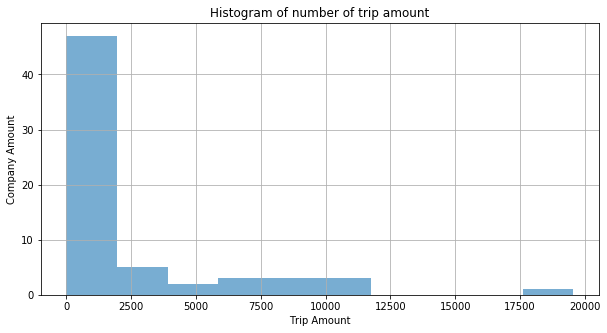

In [27]:
# plot a histogram of company. 
company['trips_amount'].hist(alpha = 0.6, figsize = (10, 5))
# add title and axis names
plt.xlabel('Trip Amount')
plt.ylabel('Company Amount')
plt.title("Histogram of number of trip amount");

There are some outliers that makes the histogram skew to the right.

In [28]:
top15_company = company.sort_values('trips_amount', ascending = False).head(15)
top15_company

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
5,Chicago Carriage Cab Corp,9181
6,City Service,8448
7,Sun Taxi,7701
8,Star North Management LLC,7455
9,Blue Ribbon Taxi Association Inc.,5953


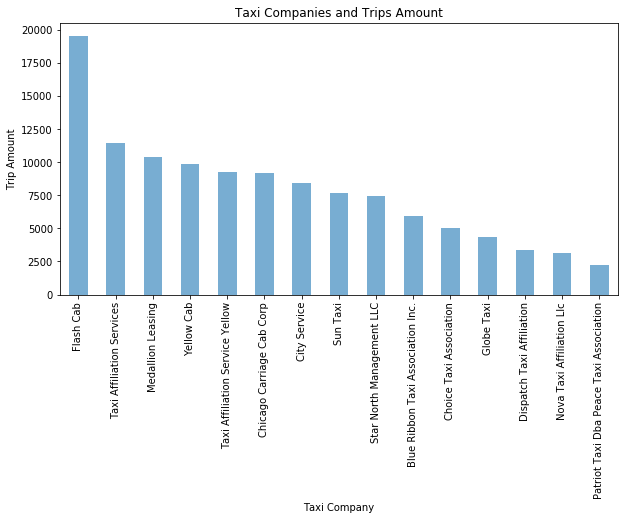

In [29]:
# plot for taxi companies with top 15 number of rides
top15_company.plot.bar(x = 'company_name', y = 'trips_amount', alpha = 0.6, figsize = (10,5), legend = False)
# add title and axis names
plt.xlabel('Taxi Company')
plt.ylabel('Trip Amount')
plt.title("Taxi Companies and Trips Amount");

I chose the top 15 taxi companies and plot a bar plot in terms of their trip amount, we concluded that `Flash Cab` is the most popular taxi company, followed by `Taxi Affilication Services` and `Medallion Leasing`.  

**Dropoff**

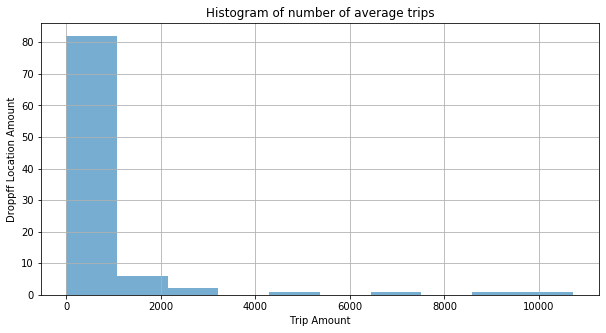

In [30]:
# plot a histogram of dropoff. 
dropoff['average_trips'].hist(alpha = 0.6, figsize = (10, 5))
# add title and axis names
plt.xlabel('Trip Amount')
plt.ylabel('Droppff Location Amount')
plt.title("Histogram of number of average trips");

There are some outliers that makes the histogram skew to the right.

In [31]:
top10_dropoff = dropoff.sort_values('average_trips', ascending = False).head(10)
top10_dropoff

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
5,Lake View,2420.966667
6,Grant Park,2068.533333
7,Museum Campus,1510.000000
8,Gold Coast,1364.233333
9,Sheffield & DePaul,1259.766667


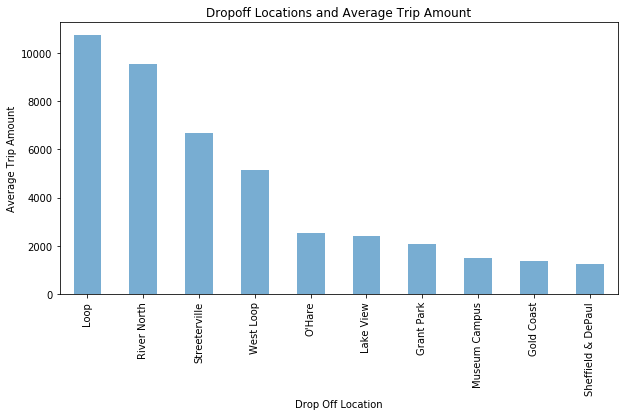

In [32]:
# plot for taxi dropoff locations with top 10 number of rides
top10_dropoff.plot.bar(x = 'dropoff_location_name', y = 'average_trips', alpha = 0.6, figsize = (10,5), legend = False)
# add title and axis names
plt.xlabel('Drop Off Location')
plt.ylabel('Average Trip Amount')
plt.title("Dropoff Locations and Average Trip Amount");

Based on the above barplot, we concluded that `Loop` is the most popular dropoff location, followed by `River North` and `Streeterville`. 

**Ohare**

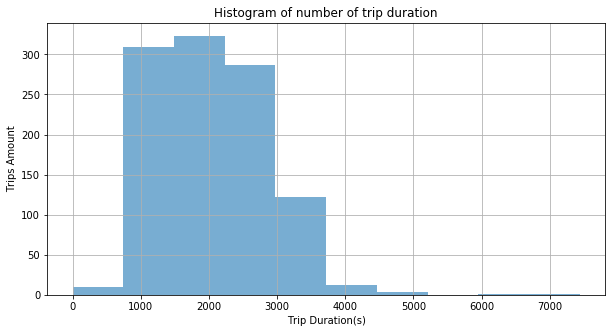

In [33]:
# plot a histogram of Ohare. 
Ohare['duration_seconds'].hist(alpha = 0.6, figsize = (10, 5))
# add title and axis names
plt.xlabel("Trip Duration(s)")
plt.ylabel('Trips Amount')
plt.title("Histogram of number of trip duration");

Most of the trips are between 1000 seconds to 3600 seconds.

## Conclusion

We identified 
* the most popular taxi company is `Flash Cab`, and it has siginificant large number of rides comparing to other companies.
* the top 10 most popular dropoff location is `Loop`, followed by `River North` and `Streeterville`. 

## Hypothesis Testing

Covert datatype of `start_ts`  to datetime

In [36]:
Ohare['start_ts'] = pd.to_datetime(Ohare['start_ts'], format='%Y-%m-%d %H:%M:%S', errors='raise')

**Test: The average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays**

In [37]:
good = Ohare[Ohare.weather_conditions.isin(['Good'])]
bad = Ohare[Ohare.weather_conditions.isin(['Bad'])]
print('The average duration of rides when the weather is sunny is', round(good['duration_seconds'].mean(), 2))
print('The average duration of rides when the weather is rainy is', round(bad['duration_seconds'].mean(), 2))

The average duration of rides when the weather is sunny is 1999.68
The average duration of rides when the weather is rainy is 2427.21


We know the average duration of rides for sunny days and rainy days are different. We want to test whether the difference is significant. The null hypothesis is there is no averate duration of rides difference between sunny and rainy days, the alternative hypothesis is the average duration of ridesg of sunny and rainy days differs. We use significant level 0.05.

* $H_0$: the average duration of rides during rainy days equals to 1999.68.
* $H_1$: the average duration of rides during rainy days doesn't equal to 1999.68. 
* $\alpha$ = 0.05
* If the p-value < $\alpha$, we reject the null hypothesis, otherwise, we fail to reject the null hypothesis.

In [ ]:
sunny = good['duration_seconds']
rainy = bad['duration_seconds']

alpha = 0.05

results = st.ttest_ind(sunny, rainy, equal_var = True)
print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis')

**Conclusion** 

Based on our testing, we reject the null hypothesis. That is, the average duration of rides of sunny and rainy days differs, and duration of rides on bad weather days is longer than good weather days.

## Overall Conclusion

In Step 1 - 3, we found that
* between November 15-16, 2017, `Yellow Cab` has the most number of rides, followed by `Taxi Affiliation Service Yellow` and `Blue Diamond`. 
* between Novenmber 1 - 7, 2017, taxi color is `Yellow` seems successful, followed by `Blue`. Zuber could consider using cars with yellow color.

In Step 4 - 5, we found that 
* the most popular taxi company is `Flash Cab`, and it has siginificant large number of rides comparing to other companies.
* the top 10 most popular dropoff location is `Loop`, followed by `River North` and `Streeterville`. Zuber could consider operate more ride services in Loop and its surrounding areas.
* the average duration of rides of sunny and rainy days differs, and duration of rides on bad weather days is longer than good weather days. Zuber could consier changing the price during rainy and stormy days. 